## Test equations

### van der Pol

\begin{align}
    \dot x &= v \\
    \dot v &= \sigma ( 1-x^2) v -x
 \end{align}
$x(0) =2$, $v(0) = 0$
### Pareschi-Russo
\begin{align}
    \dot x &= -v \\
    \dot v &= \sigma ( \sin(x)-v) + x
\end{align}
$x(0)=\pi/2$, $v(0) = 1/2$.

In both equations $\sigma$ represents the stiffness parameter. For
very large values the equations become **differential-algebraic equations of index 1** (which is easily seen if one divides by sigma and sets $1/\sigma = 0$, the remaining equation does not have derivatives = algebraic, index 1 means it is solvable). 
It is then a singular perturbation problem.
This behaviour is difficult for time-integrators insofar it reduces the error of the method to its stage-order.

We are going to test various time integration schemes. For imex schemes we treat all terms multiplied by $\sigma$ implicitly.


In order to run this notebook locally you will need
- a local instsallation of feltor: follow the quick-start guide https://github.com/feltor-dev/feltor (we do need jsoncpp and netcdf, but not glfw, and a link to path/to/feltor/inc/dg in home/include)
- a local installation of simplesimdb: follow the quick-start guide https://github.com/mwiesenberger/simplesimdb
- to compile the cpp codes in this repository: type make in a shell

In [1]:
import numpy as np
import simplesimdb as simplesim
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.animation as animation


In [2]:
# The code continuity.cpp discretizes the continuity equation
# in space and time with various schemes.
# In the following we document the possible input parameters:
def make_input() :
    return {

    "timestepper":
    {
        # We implemented various adaptive embedded Runge Kutta method
        # (see the following link for a list)
        #https://feltor-dev.github.io/doc/dg/html/structdg_1_1_e_r_k_step.html
        "type" : "adaptive",
        # "type" : "adaptive-imex",
        # "type" : "adaptive-implicit",
        "tableau" : "Bogacki-Shampine-4-2-3",
#         "controller" : "i-control",
#         "controller" : "pi-control",
        "controller" : "pid-control",
#         "controller" : "ex-control",
#         "controller" : "im-control",
#         "controller" : "imex-control"
        "rtol" : 1e-5,
        "atol" : 1e-6,
        "eps_time" : 1e-7, # should be around 1e-2 * rtol
        "reject-limit" : 10
        
    },
    "physical":
    {
        "equations" : "van-der-Pol",
#         "equations" : "Pareschi-Russo",
        "stiffness" : 5.0, # mildly stiff (Gustafsson)
#         "stiffness" : 100.0, # stiff (Gustafsson)
    },
    "output":
    {
        # The simulation will run from t = 0 to t = t_end
        "tend" : 12, # end time (Gustafsson)
    }
    }


In [3]:
# Let us run our first simulation and get an overview over
# the output file.

# We run simulations using the simplesimdb library
# In order for this to work you must first compile
# the code as described above, type:
# make continuity

# The simplesimdb library provides a simple python interface to the
# code via the Repeater class
# https://github.com/mwiesenberger/simplesimdb
rep = simplesim.Repeater("./vanderPol","temp.json", "temp.nc")
# in the following the temp.json and temp.nc files will be
# re-used for every simulation
rep.clean() # delete previously existing files
rep.run( make_input(), error="display", stdout="ignore")
# this will (i) write the input parameters to "temp.json"
# (ii) run the code, which
# (iii) produces the file "temp.nc"
ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
# Now with the help of pythons netcdf library we can pretty print
# an overview of output file
print( "FILE CONTENTS")
for v in ncin.variables:
    if v == "time" : 
        print(f"{v} {ncin.variables[v].shape}")
    else : 
        print( f"{v} {ncin.variables[v].shape}",
            f"\t{ ncin.variables[v].long_name}")
ncin.close()

FILE CONTENTS
time (376,)
first (376,) 	First variable y0
second (376,) 	Second variable y0
dt (376,) 	Proposed timestep
error (376,) 	Normalized error
nfailed (376,) 	Number of failed steps
nsteps (376,) 	Number of calls to the timestepper (including failed steps)
nex (376,) 	Number of calls to the explicit rhs
nim (376,) 	Number of calls to the implicit rhs
nsolve (376,) 	Number of calls to the implicit solver
niter (376,) 	Number of iterations in the implicit solver


In [4]:
# Here we reproduce the plot 3.1 in Gustafsson's thesis
def plot_solution( p_list, x_axis):
    frows = 3
    fcols = 1
    plt.rcParams.update({'font.size': 14})
    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*10,frows*4),dpi= 80, facecolor='w', edgecolor='k')
    #https://matplotlib.org/stable/tutorials/colors/colormaps.html

    for p in p_list :
        rep.clean()
        rep.run( p, error="display")
        ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
        x = ncin["first"][:]
        v = ncin["second"][:]
        time = ncin["time"][:]
        if x_axis == "step":
            time = np.arange( 0, np.size(time))
        dt = ncin["dt"][:]
        error = ncin["error"][:]
        last = np.size(time)-1
        
        l = f"{p['timestepper']['type']}"
        l = l + f" {p['timestepper']['tableau']}"
        l = l + f" {p['timestepper']['controller']}"
        print( "# solve ", ncin['nsolve'][last],
              " # rhs ", ncin['nex'][last],
             " # failed ", ncin["nfailed"][last], ' # '+l
             )
#         im = ax[0].plot(time,x,time,v, label=l, lw=2)
        im = ax[0].plot(time,x, label=l, lw=2)
        im = ax[1].plot(time,dt, label=l, lw=2)
        im = ax[2].plot(time,error, label=l, lw=2)
        ncin.close()
    ax[0].set_title( f"{p['physical']['equations']}")
    ax[0].set_ylabel("solution")
    ax[1].set_ylabel("stepsize")
    ax[2].set_ylabel("error")
    ax[1].set_yscale('log')
    ax[2].set_yscale('log')
    ax[2].set_ylim([1e-2, 1e1])
    for i in [0,1,2]:
        ax[i].set_xlim([0,time[np.size(time)-1]])
        ax[i].set_xlabel(x_axis)
#         ax[i].set_aspect('equal')
    for i in [0]:
        ax[i].legend()


MILDLY STIFF: s=5
# solve  678.0  # rhs  904.0  # failed  0.0  # adaptive-implicit ARK-4-2-3 (implicit) pid-control
# solve  966.0  # rhs  1289.0  # failed  0.0  # adaptive-imex ARK-4-2-3 pid-control
# solve  0.0  # rhs  1290.0  # failed  1.0  # adaptive ARK-4-2-3 (explicit) pid-control


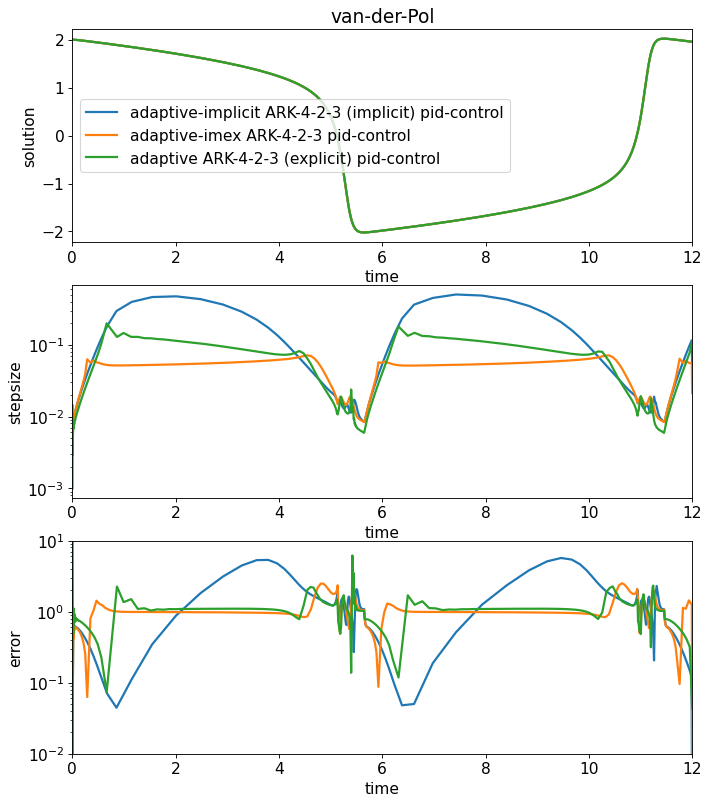

In [5]:
print( "MILDLY STIFF: s=5")
inputlist = []
ps = make_input()
ps["timestepper"]["type"] = "adaptive-implicit"
ps["timestepper"]["tableau"] = "ARK-4-2-3 (implicit)"
ps["timestepper"]["controller"]  = "pid-control"
inputlist.append(ps)
ps = make_input()
ps["timestepper"]["type"] = "adaptive-imex"
ps["timestepper"]["tableau"] = "ARK-4-2-3"
inputlist.append( ps) 
ps = make_input()
ps["timestepper"]["type"] = "adaptive"
ps["timestepper"]["tableau"] = "ARK-4-2-3 (explicit)"
inputlist.append( ps) 

plot_solution( inputlist, "time")

QUITE STIFF s=100
# solve  585.0  # rhs  780.0  # failed  3.0  # adaptive-implicit ARK-4-2-3 (implicit) pid-control
# solve  2805.0  # rhs  3743.0  # failed  2.0  # adaptive-imex ARK-4-2-3 pid-control
# solve  0.0  # rhs  24734.0  # failed  4.0  # adaptive Bogacki-Shampine-4-2-3 pid-control


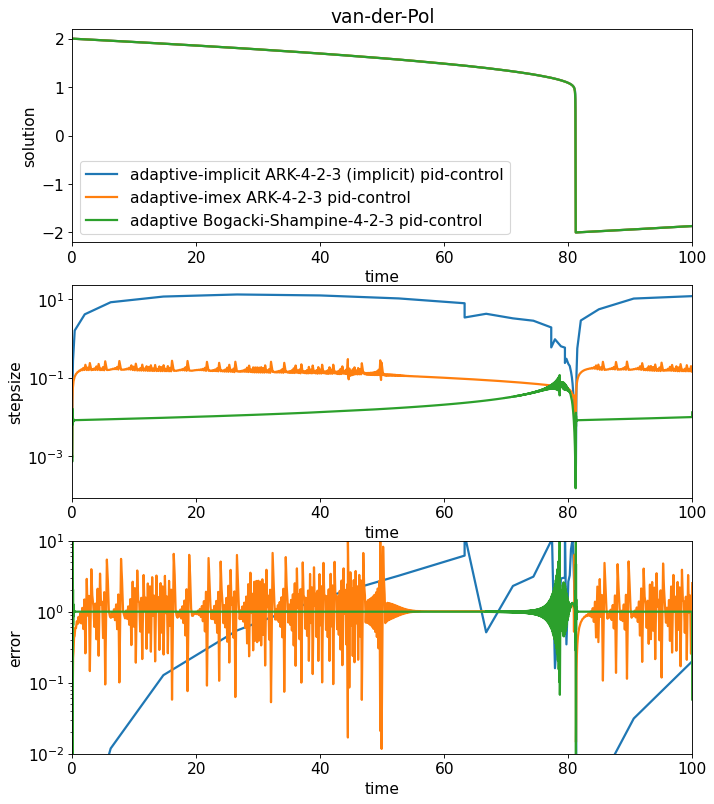

In [6]:
print("QUITE STIFF s=100")
inputlist = []
ps = make_input()
ps["physical"]["stiffness"] = 100
ps["timestepper"]["type"] = "adaptive-implicit"
ps["timestepper"]["tableau"] = "ARK-4-2-3 (implicit)"
ps["timestepper"]["controller"] = "pid-control"
ps["output"]["tend"] = 100
inputlist.append( ps) 
ps = make_input()
ps["physical"]["stiffness"] = 100
ps["timestepper"]["type"] = "adaptive-imex"
ps["timestepper"]["tableau"] = "ARK-4-2-3"
ps["timestepper"]["controller"] = "pid-control"
ps["timestepper"]["rtol"] = 1e-5
ps["timestepper"]["reject-limit"]  = 10
ps["output"]["tend"] = 100
inputlist.append( ps) 
ps = make_input()
ps["physical"]["stiffness"] = 100
ps["timestepper"]["type"] = "adaptive"
ps["timestepper"]["tableau"] = "Bogacki-Shampine-4-2-3" 
ps["timestepper"]["controller"] = "pid-control"
ps["timestepper"]["rtol"] = 1e-6
ps["output"]["tend"] = 100
inputlist.append( ps) 

plot_solution( inputlist, "time")

### Findings for IMEX timesteppers: ARK-4-2-3 , ARK-6-3-4 and ARK-8-4-5

- for mildly stiff and quite stiff problems the imex-control or ex-control may work better than the pid-control in that it produces less oscillations and requires less solves 
- unless the reject-limit is increased up to 10, then the pid-control works better again
- this is true also for various rtol values

### Findings for explicit timesteppers: Bogacki-Shampine-4-2-3, ARK-4-2-3 (explicit)
- for the default reject value 2, the **pid-control works best** overall
- Bogacki-Shampine and ARK-4-2-3 behave differently
- for small reject-value 1.1 the imex-control is better for Bogacki-Shampine
- ex-control is a valid alternative especially for the quite stiff problem

### Findings for implicit timesteppers: SDIRK-5-3-4, ARK-4-2-3 (implicit)
- for all stiffness values the above findings can be reproduced: the imex - controller outperforms the pid-controller for small reject values
- the best implicit controller is however the **im-control**

## Summary: 
- For explicit and imex schemes the pid-controller with rejct-limit 2 should be the first choice
- If the pid-controller is found to produce a lot of failed steps, then a swap to imex- or ex-control or an increased reject-limit of 10 may improve the performance
- **For implicit schemes the im-control works best**, but worst for explicit and imex schemes

QUITE STIFF s=100
reject =  1.1
# solve  3651.0  # rhs  5068.0  # failed  199.0  # adaptive-imex ARK-4-2-3 pi-control
# solve  3507.0  # rhs  4844.0  # failed  167.0  # adaptive-imex ARK-4-2-3 pid-control
# solve  3072.0  # rhs  4157.0  # failed  60.0  # adaptive-imex ARK-4-2-3 ex-control
# solve  3813.0  # rhs  5350.0  # failed  265.0  # adaptive-imex ARK-4-2-3 im-control
# solve  3009.0  # rhs  4016.0  # failed  3.0  # adaptive-imex ARK-4-2-3 imex-control
reject =  2
# solve  3825.0  # rhs  5278.0  # failed  177.0  # adaptive-imex ARK-4-2-3 pi-control
# solve  3345.0  # rhs  4562.0  # failed  101.0  # adaptive-imex ARK-4-2-3 pid-control
# solve  2871.0  # rhs  3836.0  # failed  7.0  # adaptive-imex ARK-4-2-3 ex-control
# solve  4191.0  # rhs  5850.0  # failed  261.0  # adaptive-imex ARK-4-2-3 im-control
# solve  3009.0  # rhs  4014.0  # failed  1.0  # adaptive-imex ARK-4-2-3 imex-control
reject =  10
# solve  2973.0  # rhs  3971.0  # failed  6.0  # adaptive-imex ARK-4-2-3 pi-control


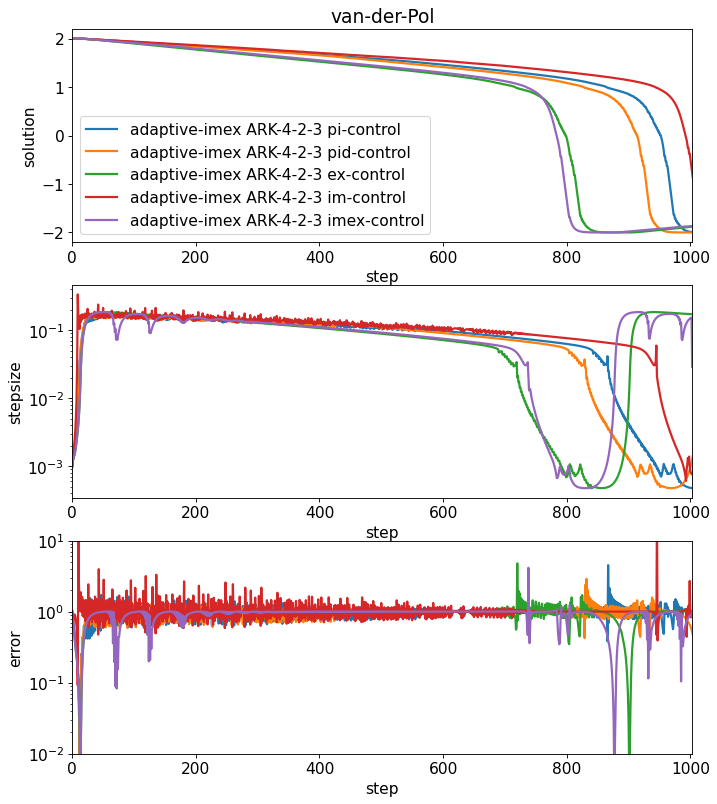

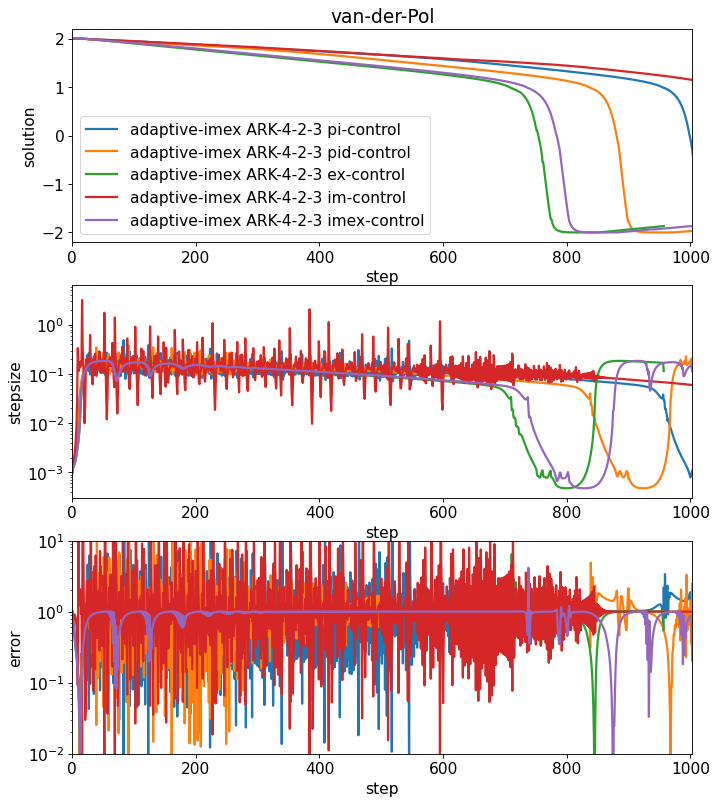

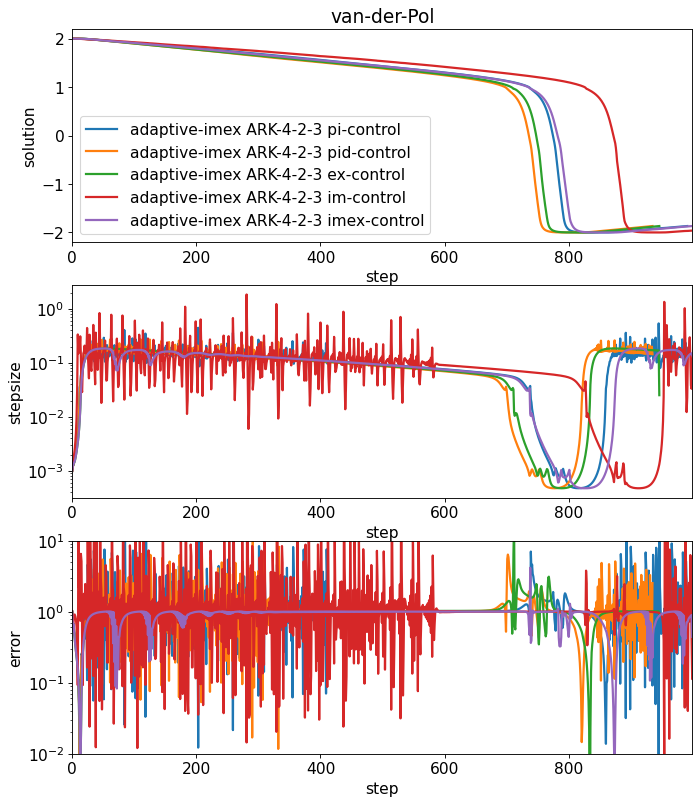

In [7]:
print("QUITE STIFF s=100")

for reject in [1.1, 2, 10]:
    inputlist = []
    print( "reject = ", reject)
    for control in ["pi-control", "pid-control", "ex-control", "im-control", "imex-control"]:
        p = make_input()
        p["physical"]["stiffness"] = 100
        p["timestepper"]["type"] = "adaptive-imex"
        p["timestepper"]["tableau"] = "ARK-4-2-3"
        p["timestepper"]["controller"] = control
        p["timestepper"]["rtol"] = 1e-5
        p["timestepper"]["eps_time"] = 1e-2*p["timestepper"]["rtol"]
        p["timestepper"]["reject-limit"]  = reject
        p["output"]["tend"] =100
        inputlist.append(p)


    plot_solution( inputlist, "step")